In [1]:
import os


In [2]:
from __future__ import print_function
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
import cv2

Using TensorFlow backend.
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ASUS\Anaconda3

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
Vld_Splt= 0.0909
batch_size = 200
num_classes = 10
epochs = 30

In [5]:
from keras.utils import np_utils

'''LOAD DATA'''
Dir= 'C:/pythonwork/MHDD/'
x_train= np.load(Dir+'HMDD_Train_X.npy')
y_train=np.load(Dir+'HMDD_Train_Y.npy')
x_test=np.load(Dir+'HMDD_Test_X.npy')
y_test=np.load(Dir+'HMDD_Test_Y.npy')

'''PRE-PROCESSING'''
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
# n_Vld= int(np.floor(Vld_Splt* x_train.shape[0]))  # Num. of validation data

In [6]:
# (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)\
#          .astype('float32')
# x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).\
#          astype('float32')
# x_train /= 255
# x_test /= 255
# y_train = utils.to_categorical(y_train, num_classes)
# y_test = utils.to_categorical(y_test, num_classes)

In [7]:
print('', x_train.shape,'\n',y_train.shape,'\n',x_test.shape,'\n',y_test.shape,'\n')

 (60000, 28, 28, 1) 
 (60000, 10) 
 (10000, 28, 28, 1) 
 (10000, 10) 



In [8]:
# the squashing function.
# we use 0.5 in stead of 1 in hinton's paper.
# if 1, the norm of vector will be zoomed out.
# if 0.5, the norm will be zoomed in while original norm is less than 0.5
# and be zoomed out while original norm is greater than 0.5.
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)


# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)


class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [9]:
"""one-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_0 = Conv2D(filters= 300, kernel_size= 3, activation='relu', 
             padding= 'valid')(input_image)
x_0= Dropout(0.1)(x_0)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_0 = Reshape((-1, 300))(x_0)
capsule_0 = Capsule(num_classes, 16, 3, True)(x_0)
output_0 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_0)
model_0 = Model(inputs= input_image, outputs= output_0)

# we use a margin loss
model_0.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_0.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 300)       3000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 300)       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 676, 300)          0         
_________________________________________________________________
capsule_1 (Capsule)          (None, 10, 16)            48000     
_________________________________________________________________
lambda_1 (Lambda)    

In [10]:
"""two-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_1 = Conv2D(filters= 20, kernel_size= 3, activation='relu', 
             padding= 'valid')(input_image)
x_1= Dropout(0.1)(x_1)
x_1 = Conv2D(filters= 150, kernel_size= 3, activation='relu',
             strides= 1)(x_1)
x_1 = Dropout(0.1)(x_1)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_1 = Reshape((-1, 150))(x_1)
capsule_1 = Capsule(num_classes, 16, 3, True)(x_1)
output_1 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_1)
model_1= Model(inputs= input_image, outputs= output_1)

# we use a margin loss
model_1.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_1.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 20)        200       
_________________________________________________________________
dropout_2 (Dropout)          (None, 26, 26, 20)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 150)       27150     
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 24, 150)       0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 576, 150)          0         
_________________________________________________________________
capsule_2 (Capsule)          (None, 10, 16)            24000     
__________

In [11]:
"""three-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_2 = Conv2D(filters= 20, kernel_size= 3, activation='relu', 
             padding= 'valid')(input_image)
x_2=  Dropout(0.1)(x_2)
x_2 = Conv2D(filters= 55, kernel_size= 3, activation='relu',
             strides= 1)(x_2)
x_2 = Dropout(0.1)(x_2)
x_2 = Conv2D(filters= 62, kernel_size= 3, activation='relu',
             strides= 1)(x_2)
x_2 = Dropout(0.1)(x_2)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_2 = Reshape((-1, 62))(x_2)
capsule_2 = Capsule(num_classes, 16, 3, True)(x_2)
output_2 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_2)
model_2= Model(inputs= input_image, outputs= output_2)

# we use a margin loss
model_2.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_2.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 20)        200       
_________________________________________________________________
dropout_4 (Dropout)          (None, 26, 26, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 55)        9955      
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 55)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 62)        30752     
_________________________________________________________________
dropout_6 (Dropout)          (None, 22, 22, 62)        0         
__________

In [12]:
"""four-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_3 = Conv2D(filters= 20, kernel_size= 3, activation='relu', 
             padding= 'valid')(input_image)
x_3= Dropout(0.1)(x_3)
x_3 = Conv2D(filters= 35,kernel_size= 3, activation='relu',
             strides= 1)(x_3)
x_3 = Dropout(0.1)(x_3)
x_3 = Conv2D(filters= 45 , kernel_size= 3, activation='relu',
             strides= 1)(x_3)
x_3= Dropout(0.1)(x_3)
x_3 = Conv2D(filters= 55, kernel_size= 3, activation='relu',
             strides= 1)(x_3)
x_3= Dropout(0.1)(x_3)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_3 = Reshape((-1, 55))(x_3)
capsule_3 = Capsule(num_classes, 16, 3, True)(x_3)
output_3 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_3)
model_3= Model(inputs= input_image, outputs= output_3)

# we use a margin loss
model_3.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_3.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 20)        200       
_________________________________________________________________
dropout_7 (Dropout)          (None, 26, 26, 20)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 35)        6335      
_________________________________________________________________
dropout_8 (Dropout)          (None, 24, 24, 35)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 22, 22, 45)        14220     
_________________________________________________________________
dropout_9 (Dropout)          (None, 22, 22, 45)        0         
__________

In [13]:
"""five-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_4 = Conv2D(filters= 20, kernel_size= 3, activation='relu', 
             padding= 'valid')(input_image)
x_4= Dropout(0.1)(x_4)
x_4 = Conv2D(filters= 30 ,kernel_size= 3, activation='relu',
             strides= 2)(x_4)
x_4 = Dropout(0.1)(x_4)
x_4 = Conv2D(filters= 30 , kernel_size= 3, activation='relu',
             strides= 1)(x_4)
x_4= Dropout(0.1)(x_4)
x_4 = Conv2D(filters= 35,kernel_size= 3, activation='relu',
             strides= 1)(x_4)
x_4= Dropout(0.1)(x_4)
x_4 = Conv2D(filters= 57,kernel_size= 3, activation='relu',
             strides= 1)(x_4)
x_4= Dropout(0.1)(x_4)

"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_4 = Reshape((-1, 57))(x_4)
capsule_4 = Capsule(num_classes, 16, 3, True)(x_4)
output_4 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_4)
model_4= Model(inputs= input_image, outputs= output_4)

# we use a margin loss
model_4.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_4.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 26, 20)        200       
_________________________________________________________________
dropout_11 (Dropout)         (None, 26, 26, 20)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 30)        5430      
_________________________________________________________________
dropout_12 (Dropout)         (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 30)        8130      
_________________________________________________________________
dropout_13 (Dropout)         (None, 10, 10, 30)        0         
__________

In [14]:
"""six-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_5 = Conv2D(filters= 20, kernel_size= 3, activation='relu', 
             padding= 'valid')(input_image)
x_5= Dropout(0.1)(x_5)
x_5 = Conv2D(filters= 25 ,kernel_size= 3, activation='relu',
             strides= 2)(x_5)
x_5 = Dropout(0.1)(x_5)
x_5 = Conv2D(filters= 30, kernel_size= 3, activation='relu',
             strides= 1)(x_5)
x_5= Dropout(0.1)(x_5)
x_5 = Conv2D(filters= 30,kernel_size= 3, activation='relu',
             strides= 1)(x_5)
x_5= Dropout(0.1)(x_5)
x_5 = Conv2D(filters= 35,kernel_size= 3, activation='relu',
             strides= 1)(x_5)
x_5= Dropout(0.1)(x_5)
x_5 = Conv2D(filters= 45,kernel_size= 3, activation='relu',
             strides= 1)(x_5)
x_5= Dropout(0.1)(x_5)

"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_5 = Reshape((-1, 45))(x_5)
capsule_5 = Capsule(num_classes, 16, 3, True)(x_5)
output_5 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_5)
model_5= Model(inputs= input_image, outputs= output_5)

# we use a margin loss
model_5.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_5.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 26, 26, 20)        200       
_________________________________________________________________
dropout_16 (Dropout)         (None, 26, 26, 20)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 12, 25)        4525      
_________________________________________________________________
dropout_17 (Dropout)         (None, 12, 12, 25)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 10, 10, 30)        6780      
_________________________________________________________________
dropout_18 (Dropout)         (None, 10, 10, 30)        0         
__________

In [15]:
"""seven-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_6 = Conv2D(filters= 20, kernel_size= 3, activation='relu', 
             padding= 'valid')(input_image)
x_6= Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 20 ,kernel_size= 3, activation='relu',
             padding= 'same')(x_6)
x_6 = Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 25, kernel_size= 3, activation='relu',
             strides= 2)(x_6)
x_6= Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 30,kernel_size= 3, activation='relu',
             strides= 1)(x_6)
x_6= Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 30,kernel_size= 3, activation='relu',
             padding= 'same')(x_6)
x_6= Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 40,kernel_size= 3, activation='relu',
             strides= 1)(x_6)
x_6= Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 40,kernel_size= 3, activation='relu',
             strides= 1)(x_6)
x_6= Dropout(0.1)(x_6)

"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_6 = Reshape((-1, 40))(x_6)
capsule_6 = Capsule(num_classes, 16, 3, True)(x_6)
output_6 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_6)
model_6= Model(inputs= input_image, outputs= output_6)

# we use a margin loss
model_6.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_6.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 26, 26, 20)        200       
_________________________________________________________________
dropout_22 (Dropout)         (None, 26, 26, 20)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 26, 26, 20)        3620      
_________________________________________________________________
dropout_23 (Dropout)         (None, 26, 26, 20)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 12, 12, 25)        4525      
_________________________________________________________________
dropout_24 (Dropout)         (None, 12, 12, 25)        0         
__________

In [16]:
"""CNN-3-CONV-LAYERS"""
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, \
                         ZeroPadding2D

model_7= Sequential()
model_7.add(Conv2D(filters= 10, kernel_size= (3, 3), padding= 'valid', 
                   input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), 
                   activation='relu'))
model_7.add(MaxPooling2D(pool_size=(2,2)))
model_7.add(Conv2D(filters= 20, kernel_size= (3, 3), 
                    padding= 'valid', activation='relu'))
model_7.add(Dropout(0.4))
model_7.add(MaxPooling2D(pool_size=(2,2)))

model_7.add(Flatten())
model_7.add(Dropout(0.5))
model_7.add(Dense(256, activation='relu'))
model_7.add(Dense(num_classes, activation='softmax'))
print(model_7.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 26, 26, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 10)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 11, 11, 20)        1820      
_________________________________________________________________
dropout_29 (Dropout)         (None, 11, 11, 20)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 500)               0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 500)               0         
__________

In [17]:
"""one-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_0= model_0.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_0= model_0.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 23s 425us/step - loss: 0.4345 - acc: 0.4163 - val_loss: 0.3724 - val_acc: 0.5389
Epoch 2/30
54546/54546 [==============================] - 20s 372us/step - loss: 0.3630 - acc: 0.5464 - val_loss: 0.3432 - val_acc: 0.6399
Epoch 3/30
54546/54546 [==============================] - 20s 373us/step - loss: 0.3389 - acc: 0.6054 - val_loss: 0.3235 - val_acc: 0.6511
Epoch 4/30
54546/54546 [==============================] - 20s 370us/step - loss: 0.3217 - acc: 0.6455 - val_loss: 0.3148 - val_acc: 0.6795
Epoch 5/30
54546/54546 [==============================] - 20s 370us/step - loss: 0.3110 - acc: 0.6714 - val_loss: 0.2960 - val_acc: 0.7123
Epoch 6/30
54546/54546 [==============================] - 20s 370us/step - loss: 0.3014 - acc: 0.6860

In [18]:
"""two-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_1= model_1.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_1= model_1.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 16s 290us/step - loss: 0.4208 - acc: 0.4788 - val_loss: 0.3376 - val_acc: 0.6377
Epoch 2/30
54546/54546 [==============================] - 15s 278us/step - loss: 0.3089 - acc: 0.6782 - val_loss: 0.2796 - val_acc: 0.7127
Epoch 3/30
54546/54546 [==============================] - 16s 299us/step - loss: 0.2648 - acc: 0.7471 - val_loss: 0.2402 - val_acc: 0.7789
Epoch 4/30
54546/54546 [==============================] - 16s 298us/step - loss: 0.2413 - acc: 0.7800 - val_loss: 0.2271 - val_acc: 0.7968
Epoch 5/30
54546/54546 [==============================] - 16s 299us/step - loss: 0.2285 - acc: 0.7947 - val_loss: 0.2076 - val_acc: 0.8317
Epoch 6/30
54546/54546 [==============================] - 16s 299us/step - loss: 0.2173 - acc: 0.8083 - val_loss: 0.1990 - val_acc: 0.8465
Epoch 7/30
54546/54546 [==============================] - 16s 300us/step - loss: 0.2089 

In [19]:
"""three-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_2= model_2.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_2= model_2.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 13s 241us/step - loss: 0.4154 - acc: 0.4671 - val_loss: 0.3034 - val_acc: 0.7241
Epoch 2/30
54546/54546 [==============================] - 12s 226us/step - loss: 0.2662 - acc: 0.7427 - val_loss: 0.2225 - val_acc: 0.8036
Epoch 3/30
54546/54546 [==============================] - 12s 226us/step - loss: 0.2170 - acc: 0.8053 - val_loss: 0.1875 - val_acc: 0.8458
Epoch 4/30
54546/54546 [==============================] - 12s 226us/step - loss: 0.1909 - acc: 0.8285 - val_loss: 0.1652 - val_acc: 0.8612
Epoch 5/30
54546/54546 [==============================] - 18s 335us/step - loss: 0.1721 - acc: 0.8458 - val_loss: 0.1594 - val_acc: 0.8607
Epoch 6/30
54546/54546 [==============================] - 12s 229us/step - loss: 0.1610 - acc: 0.8571 - val_loss: 0.1428 - val_acc: 0.8772
Epoch 7/30
54546/54546 [==============================] - 12s 229us/step - loss: 0.1512 

In [20]:
"""four-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_3= model_3.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_3= model_3.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 14s 260us/step - loss: 0.4322 - acc: 0.4002 - val_loss: 0.3316 - val_acc: 0.6036
Epoch 2/30
54546/54546 [==============================] - 13s 235us/step - loss: 0.2737 - acc: 0.7202 - val_loss: 0.2136 - val_acc: 0.8012
Epoch 3/30
54546/54546 [==============================] - 13s 231us/step - loss: 0.1998 - acc: 0.8121 - val_loss: 0.1660 - val_acc: 0.8473
Epoch 4/30
54546/54546 [==============================] - 13s 231us/step - loss: 0.1611 - acc: 0.8501 - val_loss: 0.1344 - val_acc: 0.8691
Epoch 5/30
54546/54546 [==============================] - 13s 232us/step - loss: 0.1399 - acc: 0.8724 - val_loss: 0.1156 - val_acc: 0.8962
Epoch 6/30
54546/54546 [==============================] - 12s 229us/step - loss: 0.1285 - acc: 0.8843 - val_loss: 0.1121 - val_acc: 0.8933
Epoch 7/30
54546/54546 [==============================] - 13s 234us/step - loss: 0.1188 

In [21]:
"""five-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_4= model_4.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_4= model_4.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 5s 92us/step - loss: 0.3493 - acc: 0.5289 - val_loss: 0.1949 - val_acc: 0.7957
Epoch 2/30
54546/54546 [==============================] - 4s 76us/step - loss: 0.1635 - acc: 0.8246 - val_loss: 0.1073 - val_acc: 0.8867
Epoch 3/30
54546/54546 [==============================] - 4s 76us/step - loss: 0.1128 - acc: 0.8788 - val_loss: 0.0777 - val_acc: 0.9184
Epoch 4/30
54546/54546 [==============================] - 4s 78us/step - loss: 0.0900 - acc: 0.9067 - val_loss: 0.0633 - val_acc: 0.9323
Epoch 5/30
54546/54546 [==============================] - 4s 76us/step - loss: 0.0787 - acc: 0.9178 - val_loss: 0.0618 - val_acc: 0.9303
Epoch 6/30
54546/54546 [==============================] - 5s 84us/step - loss: 0.0699 - acc: 0.9277 - val_loss: 0.0531 - val_acc: 0.9421
Epoch 7/30
54546/54546 [==============================] - 4s 75us/step - loss: 0.0632 - acc: 0.9352 

In [22]:
"""six-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_5= model_5.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_5= model_5.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 6s 104us/step - loss: 0.3575 - acc: 0.4995 - val_loss: 0.1904 - val_acc: 0.7538
Epoch 2/30
54546/54546 [==============================] - 4s 69us/step - loss: 0.1645 - acc: 0.8013 - val_loss: 0.1038 - val_acc: 0.8757
Epoch 3/30
54546/54546 [==============================] - 4s 69us/step - loss: 0.1137 - acc: 0.8649 - val_loss: 0.0771 - val_acc: 0.9054
Epoch 4/30
54546/54546 [==============================] - 4s 73us/step - loss: 0.0899 - acc: 0.8927 - val_loss: 0.0677 - val_acc: 0.9155
Epoch 5/30
54546/54546 [==============================] - 4s 79us/step - loss: 0.0769 - acc: 0.9101 - val_loss: 0.0569 - val_acc: 0.9340
Epoch 6/30
54546/54546 [==============================] - 5s 84us/step - loss: 0.0690 - acc: 0.9178 - val_loss: 0.0553 - val_acc: 0.9298
Epoch 7/30
54546/54546 [==============================] - 4s 80us/step - loss: 0.0623 - acc: 0.9264

In [23]:
"""seven-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_6= model_6.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_6= model_6.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 7s 123us/step - loss: 0.3788 - acc: 0.4549 - val_loss: 0.1888 - val_acc: 0.7906
Epoch 2/30
54546/54546 [==============================] - 5s 100us/step - loss: 0.1580 - acc: 0.8212 - val_loss: 0.0971 - val_acc: 0.8896
Epoch 3/30
54546/54546 [==============================] - 5s 100us/step - loss: 0.0958 - acc: 0.8934 - val_loss: 0.0682 - val_acc: 0.9217
Epoch 4/30
54546/54546 [==============================] - 5s 98us/step - loss: 0.0733 - acc: 0.9185 - val_loss: 0.0488 - val_acc: 0.9450
Epoch 5/30
54546/54546 [==============================] - 6s 102us/step - loss: 0.0633 - acc: 0.9286 - val_loss: 0.0437 - val_acc: 0.9499
Epoch 6/30
54546/54546 [==============================] - 6s 109us/step - loss: 0.0555 - acc: 0.9378 - val_loss: 0.0450 - val_acc: 0.9472
Epoch 7/30
54546/54546 [==============================] - 6s 103us/step - loss: 0.0496 - acc: 0

In [24]:
"""CNN-3-CONV-LAYERS"""
model_7.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
train_history_7= model_7.fit(x= x_train, y= y_train, validation_split= Vld_Splt,
                         epochs= epochs, batch_size= batch_size, verbose=1)

Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 3s 59us/step - loss: 1.3490 - acc: 0.5324 - val_loss: 0.8498 - val_acc: 0.7772
Epoch 2/30
54546/54546 [==============================] - 2s 34us/step - loss: 0.8502 - acc: 0.7156 - val_loss: 0.6371 - val_acc: 0.8377
Epoch 3/30
54546/54546 [==============================] - 2s 35us/step - loss: 0.6958 - acc: 0.7680 - val_loss: 0.5128 - val_acc: 0.8753
Epoch 4/30
54546/54546 [==============================] - 2s 34us/step - loss: 0.6008 - acc: 0.8003 - val_loss: 0.4418 - val_acc: 0.8883
Epoch 5/30
54546/54546 [==============================] - 2s 34us/step - loss: 0.5298 - acc: 0.8239 - val_loss: 0.3922 - val_acc: 0.8984
Epoch 6/30
54546/54546 [==============================] - 2s 34us/step - loss: 0.4863 - acc: 0.8388 - val_loss: 0.3560 - val_acc: 0.9096
Epoch 7/30
54546/54546 [==============================] - 2s 35us/step - loss: 0.4585 - acc: 0.8468 - val_loss: 0.3312 - val_acc:

In [25]:
"""one-CONV-LAYERS-THICK"""
scores_0= model_0.evaluate(x_test, y_test)
scores_0[1]

10000/10000 [==============================] - 1s 136us/step


0.7865

In [26]:
"""two-CONV-LAYERS-THICK"""
scores_1= model_1.evaluate(x_test, y_test)
scores_1[1]

10000/10000 [==============================] - 1s 113us/step


0.8815

In [27]:
"""three-CONV-LAYERS-THICK"""
scores_2= model_2.evaluate(x_test, y_test)
scores_2[1]

10000/10000 [==============================] - 1s 103us/step


0.9217

In [28]:
"""four-CONV-LAYERS-THICK"""
scores_3= model_3.evaluate(x_test, y_test)
scores_3[1]

10000/10000 [==============================] - 1s 101us/step


0.9431

In [29]:
"""five-CONV-LAYERS-THICK"""
scores_4= model_4.evaluate(x_test, y_test)
scores_4[1]

10000/10000 [==============================] - 1s 83us/step


0.964

In [30]:
"""six-CONV-LAYERS-THICK"""
scores_5= model_5.evaluate(x_test, y_test)
scores_5[1]

10000/10000 [==============================] - 1s 88us/step


0.9706

In [31]:
"""seven-CONV-LAYERS-THICK"""
scores_6= model_6.evaluate(x_test, y_test)
scores_6[1]

10000/10000 [==============================] - 1s 89us/step


0.9794

In [32]:
"""CNN"""
scores_7= model_7.evaluate(x_test, y_test)
scores_7[1]

10000/10000 [==============================] - 1s 61us/step


0.9406

In [33]:
import matplotlib.pyplot as plt
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

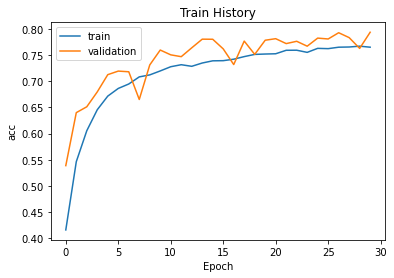

In [34]:
show_train_history(train_history_0, 'acc', 'val_acc')

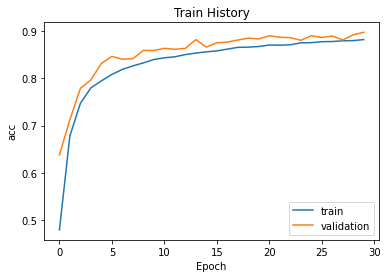

In [35]:
show_train_history(train_history_1, 'acc', 'val_acc')

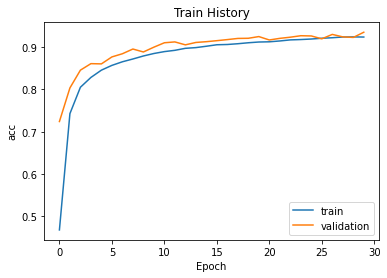

In [36]:
show_train_history(train_history_2, 'acc', 'val_acc')

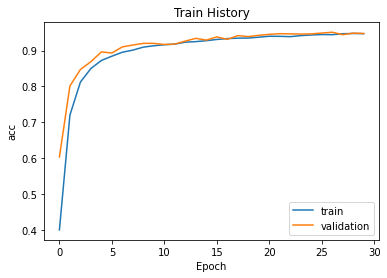

In [37]:
show_train_history(train_history_3, 'acc', 'val_acc')

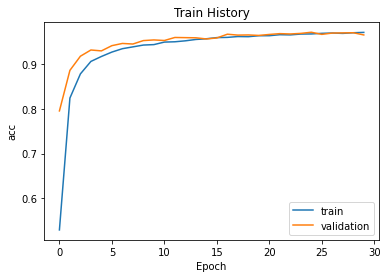

In [38]:
show_train_history(train_history_4, 'acc', 'val_acc')

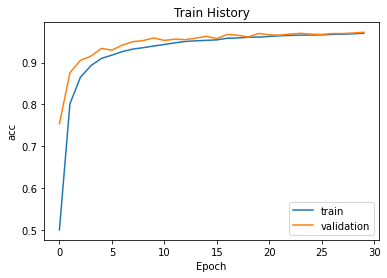

In [39]:
show_train_history(train_history_5, 'acc', 'val_acc')

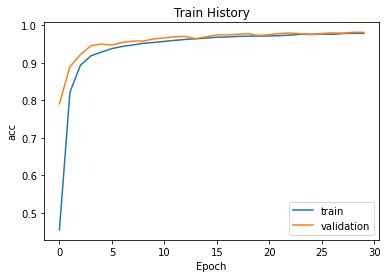

In [40]:
show_train_history(train_history_6, 'acc', 'val_acc')

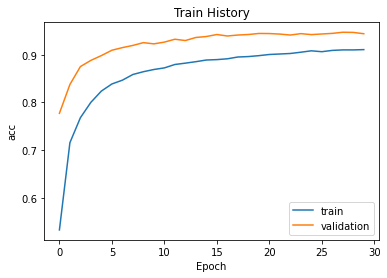

In [41]:
show_train_history(train_history_7, 'acc', 'val_acc')

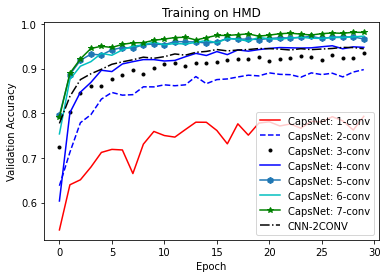

In [42]:
plt.plot(train_history_0.history['val_acc'], 'r-')
plt.plot(train_history_1.history['val_acc'], 'b--')
plt.plot(train_history_2.history['val_acc'], 'k.')
plt.plot(train_history_3.history['val_acc'], 'b-')
plt.plot(train_history_4.history['val_acc'], 'h-')
plt.plot(train_history_5.history['val_acc'], 'c-')
plt.plot(train_history_6.history['val_acc'], 'g*-')
plt.plot(train_history_7.history['val_acc'], 'k-.')
plt.title('Training on HMD')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['CapsNet: 1-conv','CapsNet: 2-conv','CapsNet: 3-conv','CapsNet: 4-conv','CapsNet: 5-conv','CapsNet: 6-conv',
           'CapsNet: 7-conv','CNN-2CONV'], loc='best')
plt.show()